# Make 2d visualisation of different samples overlays

- All images were oriented during images to align the limb dorsal-ventral axis and z-axis of an image. However, this alignment is approximate and has to be corrected.
- Due to the intrest of the current work the most important 1d direction is a line passing through SHH and FGF8 regions centers $ \mathbf{SF} $.
- Also the blastema has the characteristic shape in 3d, which can be descrioed by its PCA axis: $\mathbf{p_0}$, $\mathbf{p_2}$, $\mathbf{p_2}$.
- $ \mathbf{SF} $ defines the family of planes passing through it, to choose the plane for visualisation, we are looking for the plane closest to the plane perpendicular $\mathbf{p_0}$ (PCA axis with the smalles eigen value).

# Implementation of optimal orientation selection

The plane corresponding to the plane, passing through $ \mathbf{SF}$ and closest to the plane perpendicular to $\mathbf{p_0}$ can be defined by its orthogonal vector:
$$
\mathbf{N_{\text{desired}}} = \mathbf{SF} \times (\mathbf{SF} \times \mathbf{p_0}),
$$

which, for visualization, will be oriented along the z-axis of each image.

In [1]:
import numpy as np
import os
import re
import pandas as pd
import matplotlib.pylab as plt

import napari

from image_analysis.read_files import get_paths, change_paths
from image_analysis.fit import plot, roi, regionprops
from image_analysis.preprocess import mask

/home/natalia/miniconda3/envs/axolotl/lib/python3.11/site-packages/pytools/persistent_dict.py:52: RecommendedHashNotFoundWarning: Unable to import recommended hash 'siphash24.siphash13', falling back to 'hashlib.sha256'. Run 'python3 -m pip install siphash24' to install the recommended hash.
  warn("Unable to import recommended hash 'siphash24.siphash13', "


In [2]:
pixel_size = 8

In [3]:
pc = 50

In [4]:
folder_pretreated = r'example_pretreated_images'
df = pd.read_excel("example_images.xlsx")

In [5]:
df_to_plot = df[df['Animal size, cm'] == 3]

In [6]:
df_to_plot

,Sample name,HCR,"Animal size, cm","Regeneration time, dpa","Exact animal size (snout to tail), cm"
0,hcr21_2_5cm_6dpa_noif,21,3,6,2.7
1,hcr21_2_5cm_6dpa_p_hist,21,3,6,2.7
2,hcr21_2_5cm_7dpa_noif,21,3,7,2.9


# Find plane to show: plane trough SF closest to p1p2

In [7]:
ex = np.array([0,0,1])
ey = np.array([0,-1,0])
ez = np.cross(ex, ey)

In [8]:
i = 1
file_name = df_to_plot['Sample name'].values[i]
    
file = os.path.join( folder_pretreated, file_name) + '.npy'

keys = np.load( file.split('.npy')[0] + '_keys.npy' )
image = dict(zip(
    keys,
    np.load( file )
))

    
image = dict(zip(
    ['shh_mask', 'dusp_mask', 'fgf_mask', 'tissue_mask_with_epi'],
    [ (image[f'shh{pc}_clip'] > 0).astype(int),  (image[f'dusp{pc}_clip']>0).astype(int), (image[f'fgf{pc}_clip']>0).astype(int), image['tissue_mask_with_epi'] ]
))

image['shh_mask'] = mask.largest_component( image['shh_mask'] )
image['dusp_mask'] = mask.largest_component( image['dusp_mask'] )
image['fgf_mask'] = mask.largest_component( image['fgf_mask'] )
 
regionprops_3d = regionprops.regionprops_3d(image, 1, 1, 1, pixel_size)
regionprops_3d.center_mass(['shh_mask', 'fgf_mask'])
regionprops_3d.tensor_inertia('tissue_mask_with_epi')

SF = np.array( regionprops_3d.parm['cm_fgf_mask'] - regionprops_3d.parm['cm_shh_mask'] )

i = 0
p0 = (1/regionprops_3d.parm['lams_tissue_mask_with_epi'][i])*regionprops_3d.parm['v_tissue_mask_with_epi'][i]

N_desired = regionprops.compute_N_desired(p0, SF)

/home/natalia/Documents/axolotl_limb_regeneration_s/image_analysis/image_analysis/image_analysis/fit/regionprops.py:24: RuntimeWarning: Mean of empty slice
  img_arr_x = np.nanmean(np.nanmean(img_arr, axis=0), axis=0)
/home/natalia/Documents/axolotl_limb_regeneration_s/image_analysis/image_analysis/image_analysis/fit/regionprops.py:27: RuntimeWarning: Mean of empty slice
  img_arr_y = np.nanmean(np.nanmean(img_arr, axis=0), axis=1)
/home/natalia/Documents/axolotl_limb_regeneration_s/image_analysis/image_analysis/image_analysis/fit/regionprops.py:30: RuntimeWarning: Mean of empty slice
  img_arr_z = np.nanmean(np.nanmean(img_arr, axis=1), axis=1)


In [9]:
image = regionprops_3d.rotate_N_desired_to_ez()

regionprops_3d = regionprops.regionprops_3d(image, 1, 1, 1, pixel_size)
regionprops_3d.center_mass(['shh_mask', 'fgf_mask'])
regionprops_3d.tensor_inertia('tissue_mask_with_epi')

SF = np.array( regionprops_3d.parm['cm_fgf_mask'] - regionprops_3d.parm['cm_shh_mask'] )
p0 = (1/regionprops_3d.parm['lams_tissue_mask_with_epi'][0])*regionprops_3d.parm['v_tissue_mask_with_epi'][0]
N_desired = regionprops.compute_N_desired(p0, SF)

4 warnings generated.


Angle between ez and N_desired: -3


4 warnings generated.
/home/natalia/Documents/axolotl_limb_regeneration_s/image_analysis/image_analysis/image_analysis/fit/regionprops.py:24: RuntimeWarning: Mean of empty slice
  img_arr_x = np.nanmean(np.nanmean(img_arr, axis=0), axis=0)
/home/natalia/Documents/axolotl_limb_regeneration_s/image_analysis/image_analysis/image_analysis/fit/regionprops.py:27: RuntimeWarning: Mean of empty slice
  img_arr_y = np.nanmean(np.nanmean(img_arr, axis=0), axis=1)
/home/natalia/Documents/axolotl_limb_regeneration_s/image_analysis/image_analysis/image_analysis/fit/regionprops.py:30: RuntimeWarning: Mean of empty slice
  img_arr_z = np.nanmean(np.nanmean(img_arr, axis=1), axis=1)


In [10]:
scale_u = (pixel_size, pixel_size, pixel_size)
viewer = napari.Viewer()
viewer.add_image(image['tissue_mask_with_epi'], name='tissue_mask_with_epi', scale=scale_u)
viewer.add_image(image['shh_mask'], name='shh_mask', gamma=0.2, opacity=0.5, colormap="red", scale=scale_u)
viewer.add_image(image['fgf_mask'], name='fgf_mask', gamma=0.2, opacity=0.5, colormap="blue", scale=scale_u)

viewer.axes.visible = True
viewer.scale_bar.visible = True
viewer.scale_bar.unit = "um"

viewer.add_points(regionprops_3d.parm['cm_shh_mask'], name='cm_shh', face_color='red')
viewer.add_points(regionprops_3d.parm['cm_fgf_mask'], name='cm_fgf', face_color='blue')

vector_line = np.array([ regionprops_3d.parm['cm_shh_mask'], regionprops_3d.parm['cm_fgf_mask'] ])
viewer.add_shapes(vector_line, shape_type='line', name='SF', edge_color='gray')

vector_line = np.array([ regionprops_3d.parm['cm_shh_mask'], regionprops_3d.parm['cm_shh_mask'] + 10*N_desired ])
viewer.add_shapes(vector_line, shape_type='line', name='N_desired', edge_color='black')

vector_line = np.array([ regionprops_3d.parm['cm_shh_mask'], regionprops_3d.parm['cm_shh_mask'] + 100*ez ])
viewer.add_shapes(vector_line, shape_type='line', name='ez', edge_color='blue')

<Shapes layer 'ez' at 0x7526143fe790>

In [11]:
keys_dpa = set( [str(h) for h in df_to_plot['Regeneration time, dpa'].values] )
keys_dpa

{'6', '7'}

# Orient all

In [12]:
ex = np.array([0,0,1])
ey = np.array([0,-1,0])
ez = np.cross(ex, ey)

In [13]:
img = dict.fromkeys(keys_dpa, 0)

for tkey in keys_dpa:
    
    df_t  = df_to_plot[df_to_plot['Regeneration time, dpa'] == int(tkey)]
    df_t  = df_t.reset_index(drop=True)
    nkeys = [str(i+1) for i in range(0, len(df_t))]
    img[tkey]  = dict.fromkeys(nkeys, 0)

    for index, row in df_t.iterrows():
        
        print(row['Sample name'])
        
        path = row['Sample name']
        keys = np.load( os.path.join(folder_pretreated, path + '_keys.npy') )
        
        image = dict(
            zip(
                keys, 
                np.load( os.path.join(folder_pretreated, path + '.npy') )
            )
        )

        if f'dusp{pc}_clip' in keys:
            image = dict(zip(
                ['shh_mask', 'dusp_mask', 'fgf_mask', 'tissue_mask_with_epi'],
                [ (image[f'shh{pc}_clip'] > 0).astype(int),  (image[f'dusp{pc}_clip']>0).astype(int), (image[f'fgf{pc}_clip']>0).astype(int), image['tissue_mask_with_epi'] ]
            ))
        else:
            image = dict(zip(
                ['shh_mask', 'dusp_mask', 'fgf_mask', 'tissue_mask_with_epi'],
                [ (image[f'shh{pc}_clip'] > 0).astype(int),  0*(image[f'shh{pc}_clip']>0).astype(int), (image[f'fgf{pc}_clip']>0).astype(int), image['tissue_mask_with_epi'] ]
            ))  
        
        image['shh_mask'] = mask.largest_component( image['shh_mask'] )
        image['dusp_mask'] = mask.largest_component( image['dusp_mask'] )
        image['fgf_mask'] = mask.few_largest_components( image['fgf_mask'], 2 )

        # align

        regionprops_3d = regionprops.regionprops_3d(image, 1, 1, 1, pixel_size)
        regionprops_3d.center_mass(['shh_mask', 'fgf_mask'])
        regionprops_3d.tensor_inertia('tissue_mask_with_epi')

        if row['Sample name'] not in ['hcr21_lb68_fr', 'hcr21_lb66_fr']:
            image = regionprops_3d.rotate_N_desired_to_ez()
        else:
            image = regionprops_3d.rotate_N_desired_to_ez_special()
                    
        S = np.array( regionprops.center_mass( image['shh_mask'] ) )
        F = np.array( regionprops.center_mass( image['fgf_mask'] ) )
        SF = F - S
        
        print(S[0], F[0])
        
        # z-slice
        for key in image.keys():
            image[key] = roi.mean_nonzero( image[key], 0)
            if 'mask' in key:
                image[key] = (image[key] > 0) * 1
        img[tkey][str(index+1)] = dict(zip([path], [image]))

hcr21_2_5cm_6dpa_noif
Angle between ez and N_desired: 0
22 22
hcr21_2_5cm_6dpa_p_hist
Angle between ez and N_desired: -4
29 26
hcr21_2_5cm_7dpa_noif


/home/natalia/Documents/axolotl_limb_regeneration_s/image_analysis/image_analysis/image_analysis/fit/regionprops.py:24: RuntimeWarning: Mean of empty slice
  img_arr_x = np.nanmean(np.nanmean(img_arr, axis=0), axis=0)
/home/natalia/Documents/axolotl_limb_regeneration_s/image_analysis/image_analysis/image_analysis/fit/regionprops.py:27: RuntimeWarning: Mean of empty slice
  img_arr_y = np.nanmean(np.nanmean(img_arr, axis=0), axis=1)
/home/natalia/Documents/axolotl_limb_regeneration_s/image_analysis/image_analysis/image_analysis/fit/regionprops.py:30: RuntimeWarning: Mean of empty slice
  img_arr_z = np.nanmean(np.nanmean(img_arr, axis=1), axis=1)
/home/natalia/Documents/axolotl_limb_regeneration_s/image_analysis/image_analysis/image_analysis/fit/roi.py:67: RuntimeWarning: Mean of empty slice
  arr = np.nanmean(arr, axis=axis_n)
/home/natalia/Documents/axolotl_limb_regeneration_s/image_analysis/image_analysis/image_analysis/fit/roi.py:69: RuntimeWarning: invalid value encountered in cast

Angle between ez and N_desired: 9
21 22


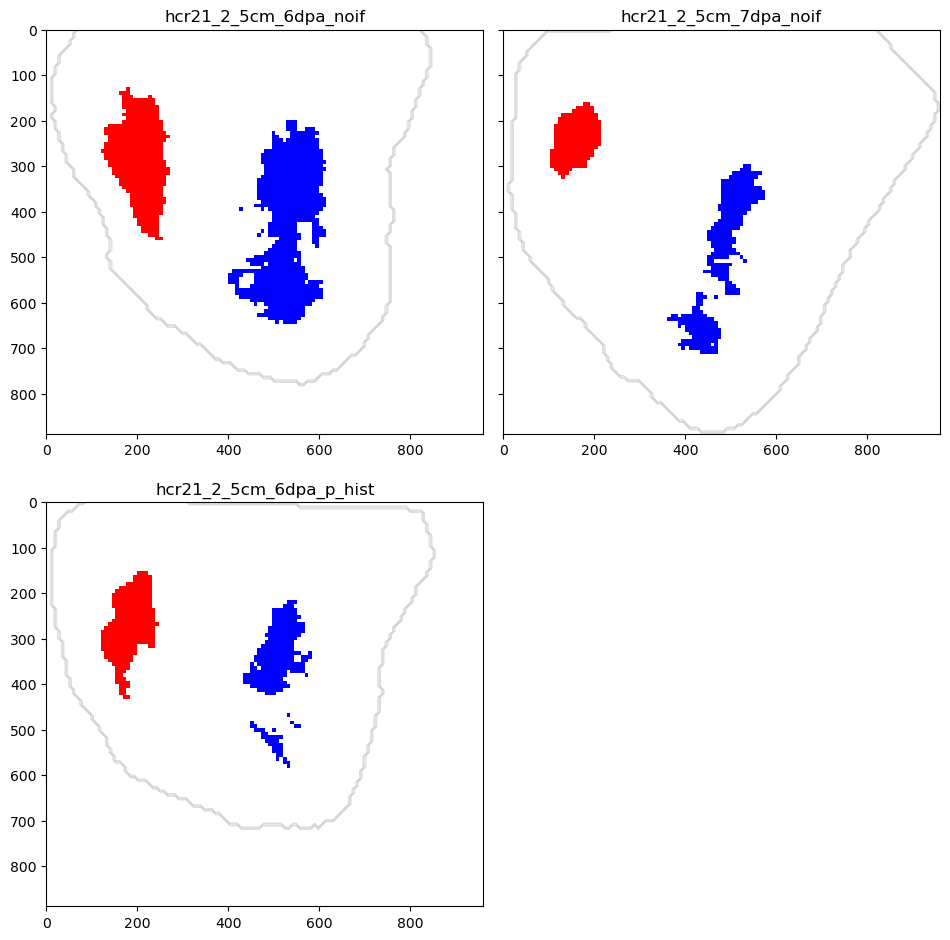

In [14]:
plot.shh_fgf_red_blue(img, pixel_size, 'shh_mask', 'fgf_mask', 100)
plt.show()

# Orient SF horizontally

In [15]:
ex_2d = np.array([0,1])

In [16]:
for tkey in img.keys():
    for nkey in img[tkey].keys():
        for file in img[tkey][nkey].keys():

            #img[tkey][nkey][file]['shh_mask'] = img[tkey][nkey][file]['shh_mask'] * mask.largest_component( img[tkey][nkey][file]['shh_mask'] > 0 )
            #img[tkey][nkey][file]['fgf_mask'] = img[tkey][nkey][file]['fgf_mask'] * mask.largest_component( img[tkey][nkey][file]['fgf_mask'] > 0 )
        
            S = regionprops.center_mass(img[tkey][nkey][file]['shh_mask'])
            F = regionprops.center_mass(img[tkey][nkey][file]['fgf_mask'])
            
            SF   = F - S
            
            rot_x = 0
            rot_y = 0
            rot_z = roi.angle_between_2d(
                    SF, 
                    ex_2d
                )      
            print(rot_z)
            
            img[tkey][nkey][file] = roi.rotate(img[tkey][nkey][file], rot_x, rot_y, rot_z)
            #img[tkey][nkey][file] = roi.flip(img[tkey][nkey][file], 1)

-22.306205054907625
-16.31385242626054
-39.36931724236474


/home/natalia/Documents/axolotl_limb_regeneration_s/image_analysis/image_analysis/image_analysis/fit/regionprops.py:37: RuntimeWarning: Mean of empty slice
  img_arr_x = np.nanmean(img_arr, axis=0)
/home/natalia/Documents/axolotl_limb_regeneration_s/image_analysis/image_analysis/image_analysis/fit/regionprops.py:40: RuntimeWarning: Mean of empty slice
  img_arr_y = np.nanmean(img_arr, axis=1)
4 warnings generated.
4 warnings generated.


In [17]:
img.keys()

dict_keys(['6', '7'])

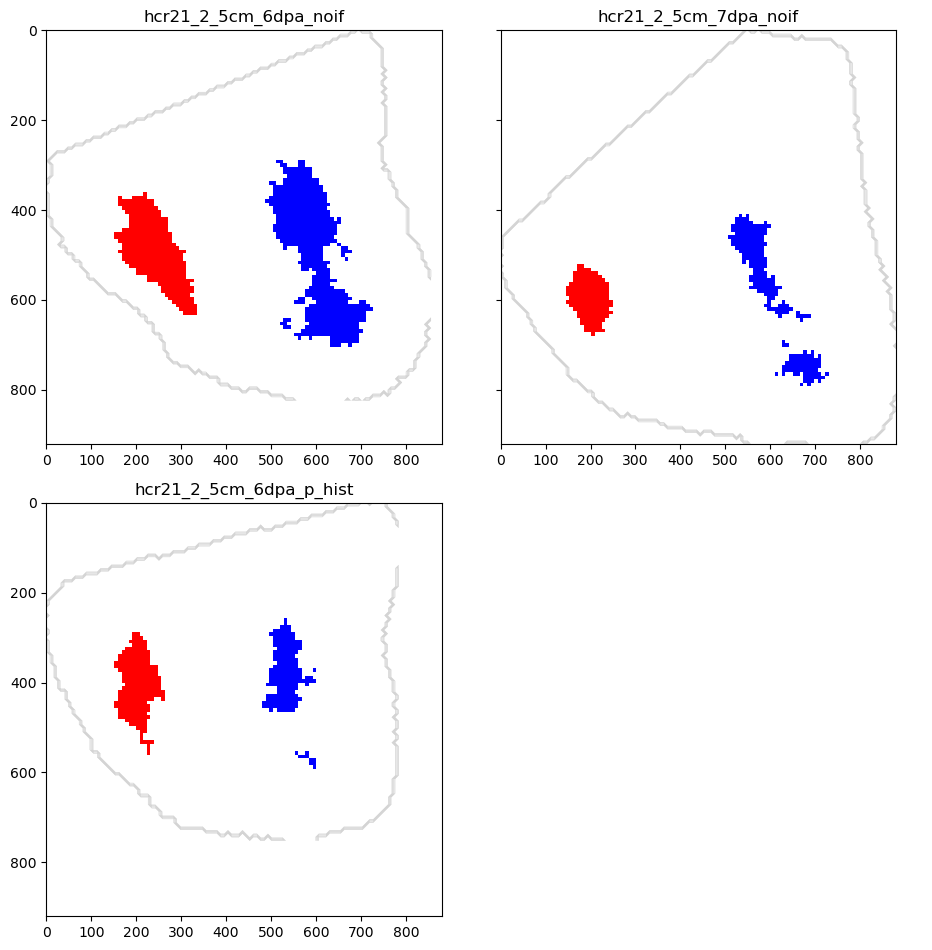

In [18]:
plot.shh_fgf_red_blue(img, pixel_size, 'shh_mask', 'fgf_mask', 100)
plt.show()

# Make all images the same size

In [19]:
size = 200

In [20]:
for tkey in img.keys():
    for nkey in img[tkey].keys():
        for file in img[tkey][nkey].keys():
            
            # expand
            j, i = img[tkey][nkey][file]['shh_mask'].shape        
            for mkey in img[tkey][nkey][file].keys():
                arr = np.zeros( [size, size] ) 
                arr[0:j, 0:i] = img[tkey][nkey][file][mkey]
                img[tkey][nkey][file][mkey] = arr

            # shift
            S = regionprops.center_mass(img[tkey][nkey][file]['shh_mask'])
            F = regionprops.center_mass(img[tkey][nkey][file]['fgf_mask'])
            
            SF_middle = (S + F)/2
            
            for mkey in img[tkey][nkey][file].keys():
                shift_0 = int( size/2 -  SF_middle[0] )
                img[tkey][nkey][file][mkey] = np.roll(img[tkey][nkey][file][mkey], shift_0, 0)  
                
                shift_1 = int( size/2 - SF_middle[1] )
                img[tkey][nkey][file][mkey] = np.roll(img[tkey][nkey][file][mkey], shift_1, 1)            

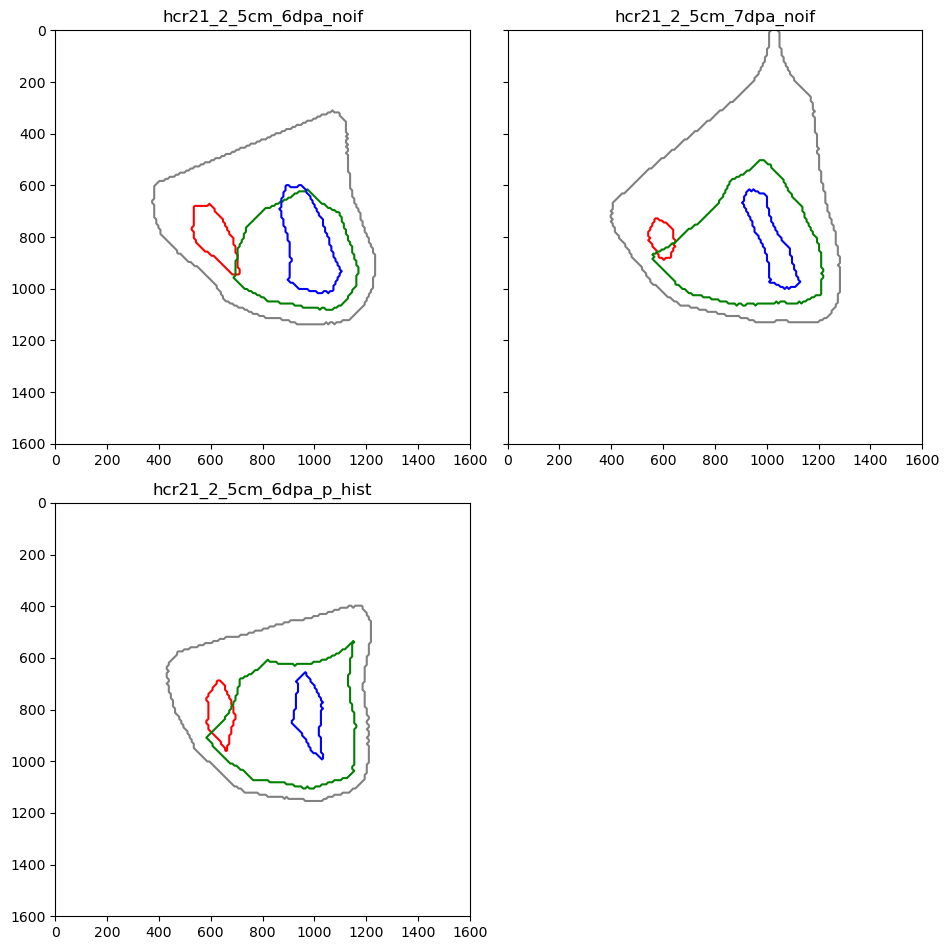

In [21]:
plot.shh_dusp_fgf_rgb(img, pixel_size, 'shh_mask', 'dusp_mask', 'fgf_mask', 100)
plt.show()

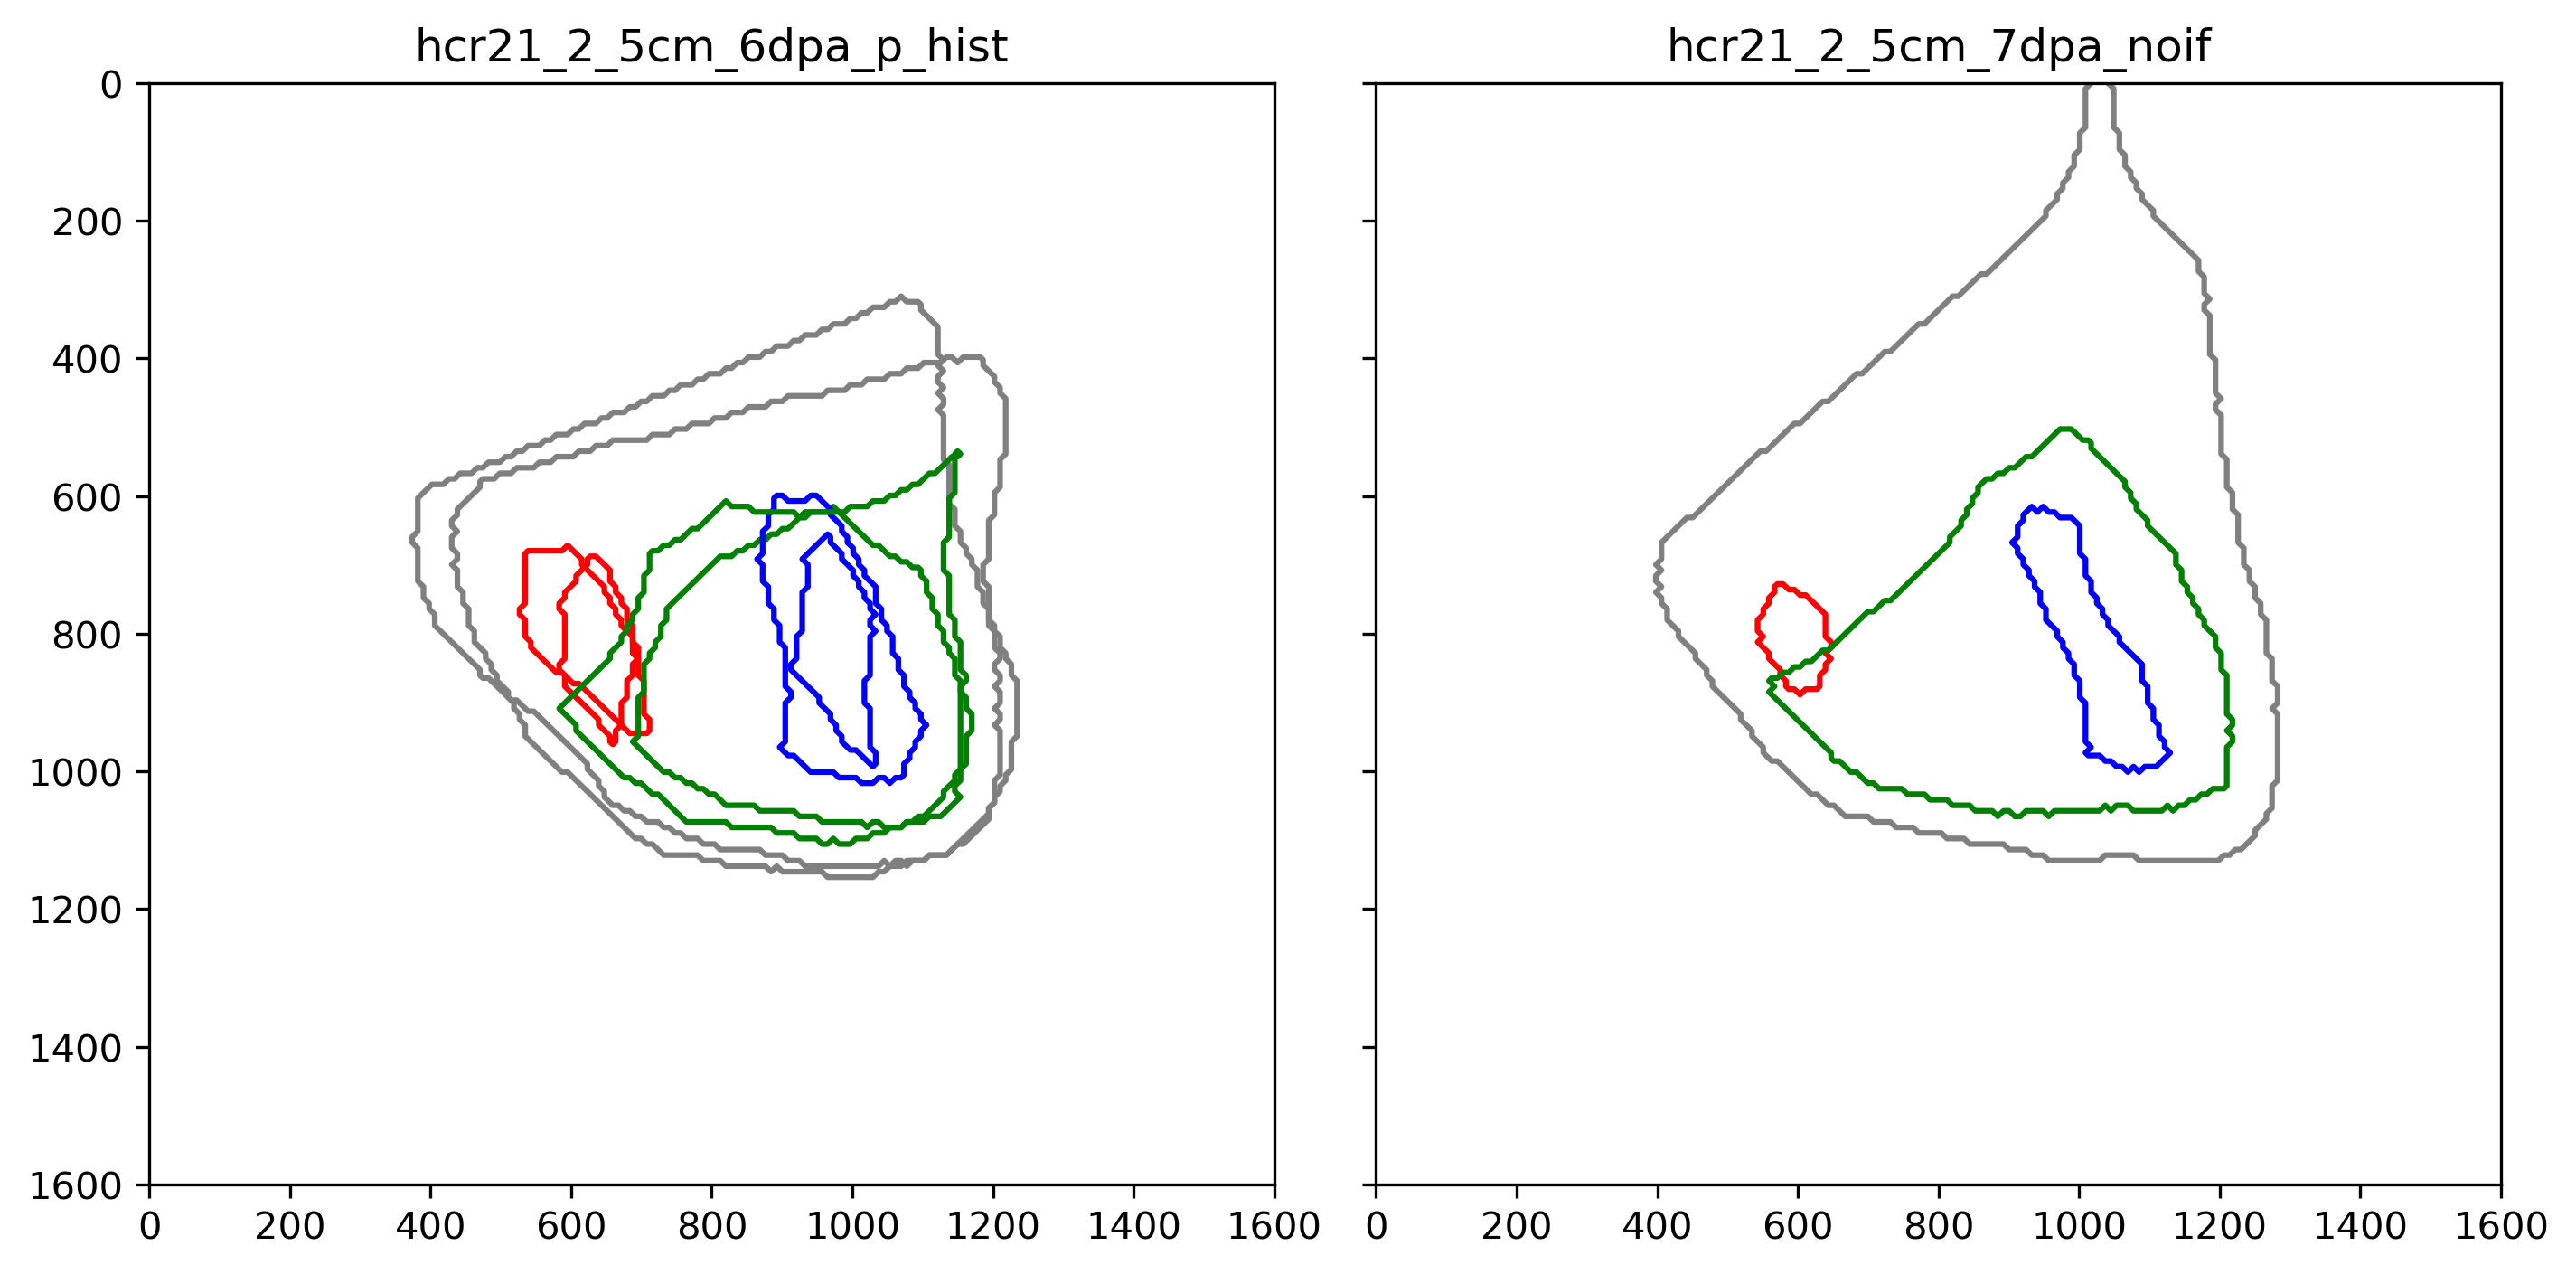

In [22]:
plot.overlay_n(img, pixel_size, size, 'shh_mask', 'dusp_mask', 'fgf_mask', 300)
plt.savefig('fig/overlay_example.pdf')
plt.show()